In [109]:
#Import libraries
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib import ticker
import itertools
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale

In [2]:
#Ensure reproducibility
random.seed(1)
np.random.seed(1)

In [1]:
class model(object):
    '''
    This class implements the CP model of human vision 
    as described in "Modeling learned categorical perception in human vision"
    Casey and Snowdon (2012)
    '''

    def __init__(self, M_PC=7, M_EC=7, M_VV=7, W_c=0.4, mu_PC=0.6, mu_EC=0.4, mu_VV=0.2, rho=1, eta=0.01):
        
  
        #Activation vectors
        self.f_u_PC = np.zeros(M_PC)                                         #Pre-cortical activity
        self.f_u_EC = np.zeros(M_EC)                                         #Early cortical activity
        self.f_u_VV = np.zeros(M_VV)                                         #Ventral visual activity
        
        #Weights
        self.W_PC = np.random.normal(0, 0.5, 9*M_PC).reshape((9, M_PC))        #Pre-cortical weights
        self.W_EC = np.random.normal(0, 0.5, M_PC*M_EC).reshape((M_PC, M_EC))  #Early visual cortex weights
        self.W_VV = np.random.normal(0, 0.5, M_EC*M_VV).reshape((M_EC, M_VV)) #Ventral visual weights
        self.W_c = W_c                                                         #Category input weight
        
        #Parameters
        self.mu_PC = mu_PC                                                   #Pre-cortical Inhibtion rate
        self.mu_EC = mu_EC                                                   #Early cortical Inhibtion rate
        self.mu_VV = mu_VV                                                   #Ventral visual Inhibtion rate      
        self.eta = eta                                                       #Learning rate                            
        self.rho = rho                                                       #Weight change threshold
      
    def activation(self, x, module, cat_input=0):
        '''
        This function computes the activation of the module specified as an argument and given an input. 
        Cat_input is only 1 when a stimulus belonging to category B is presented AND the model is in category training
        Returns the activation vector.
        Module 0: precortical, module 1:early cortical, module 2:ventral visual
        '''
        if module == 0:
            weights = self.W_PC
            mu = self.mu_PC
        elif module == 1:
            weights = self.W_EC
            mu = self.mu_EC
        else:
            weights = self.W_VV
            mu = self.mu_VV
            
        # Equations 4 and 6
        f_u = np.dot(x, weights)    
        y_win_i = np.argmax(f_u)
        
        if not np.isscalar(y_win_i):
            y_win_i = np.random.choice(y_win_i)
        for k in range(len(f_u)):
            if f_u[k] > 1:
                f_u[k] = 1
            elif f_u[k] < 0:
                f_u[k] = 0
        
        y_win = np.amax(f_u)
        
        #Provide category input to module 2
        if module == 2:
            f_u += self.W_c*cat_input
        
        # Equation 5
        for i in f_u:
            if i < f_u[y_win_i]:
                i -= mu*y_win
                
        if module == 0:
            self.f_u_PC = f_u
        elif module == 1:
            self.f_u_EC = f_u
        else:
            self.f_u_VV = f_u
        
        return f_u
    
    def update(self, x, module, cat_input=0, category_training=False):
        '''
        This function updates the weights of the module specified as an argument given an input x
        Trigger category training for the 3rd module only.
        Layer 0: PC; Layer 1: EC; Layer 2: VV
        '''
        # Equation 8
        if category_training:
            ar = np.append(x, cat_input)
            mean_x = np.mean(ar)
        else:
            mean_x = np.mean(x)
     
        # Equation 7 
        if module == 0:
            w_ = np.zeros((self.W_PC.shape[0], self.W_PC.shape[1]))
            for i in range(self.W_PC.shape[0]):
                for j in range(self.W_PC.shape[1]):
                    if x[i] > self.rho*mean_x:
                        w_[i, j] = self.W_PC[i,j] + self.eta*x[i]*self.f_u_PC[j]
                    else:
                        w_[i, j] = self.W_PC[i,j]
                        
        elif module == 1:
            w_ = np.zeros((self.W_EC.shape[0], self.W_EC.shape[1]))
            for i in range(self.W_EC.shape[0]):
                for j in range(self.W_EC.shape[1]):
                    if x[i] > self.rho*mean_x:
                        w_[i, j] = self.W_EC[i,j] + self.eta*x[i]*self.f_u_EC[j]
                    else:
                        w_[i, j] = self.W_EC[i,j]
                        
        else:
            w_ = np.zeros((self.W_VV.shape[0], self.W_VV.shape[1]))
            for i in range(self.W_VV.shape[0]):
                for j in range(self.W_VV.shape[1]):
                    if x[i] > self.rho*mean_x:
                        w_[i, j] = self.W_VV[i,j] + self.eta*x[i]*self.f_u_VV[j]
                    else:
                        w_[i, j] = self.W_VV[i,j]
                        
            if category_training:
                w_ = np.concatenate((w_, [np.repeat(self.W_c, self.W_VV.shape[1])]))
                i = w_.shape[0] -1
                x_cat = cat_input*self.W_c
                for j in range(self.W_VV.shape[1]):
                    if x_cat > self.rho*mean_x:
                        w_[i, j] += self.eta*x_cat*self.f_u_VV[j]
                    
        # Equation 9
        mean_w = np.mean(w_, axis=0)
        if module == 0:
            self.W_PC = w_/mean_w
        elif module == 1:
            self.W_EC = w_/mean_w
        else:
            if category_training:
                self.W_VV = w_[:w_.shape[0]-1]/mean_w
            else:
                self.W_VV = w_/mean_w

In [4]:
def gabor_stimuli(S_o=45, o=45, lambda_p=106, lambda_o=30, f_comp=0):
    
    #Categories
    A = []
    B = []
    
    #Phases
    P_a = [[0, 45, 90, 135, 180, 225, 270, 225], [0, 45, 90, 135, 180, 225, 270, 315], 
           [0, 45, 90, 135, 180, 225, 270, 315], [360, 45, 90, 135, 180, 225, 270, 315]]
    P_b = [[0, 45, 90, 135, 180, 135, 90, 45], [0, 45, 90, 135, 180, 225, 180, 135],
          [360, 405, 90, 135, 180, 225, 270, 315], [360, 405, 450, 135, 180, 225, 270, 315]]
    P_A = [90, 135, 180, 225]       
    P_B = [0, 45, 270, 315]
    
    #Parameters
    Lambda_p = (-math.log(1/2))/math.pow(lambda_p/2, 2) # Phase bandwidth parameter (Equation 2)
    Lambda_o = (-math.log(1/2))/math.pow(lambda_o/2, 2) # Orientation bandwidth parameter (Equation 3)
    
    for i in range(4):
        S_p_A = P_A[i]
        S_p_B = P_B[i]
        stim_A = []
        stim_B = []
        for (p_a, p_b) in zip(P_a[i], P_b[i]):
            x_A = math.exp(-Lambda_p*math.pow(p_a-S_p_A, 2)-Lambda_o*math.pow(o-S_o, 2)) # Equation 1
            x_B = math.exp(-Lambda_p*math.pow(p_b-S_p_B, 2)-Lambda_o*math.pow(o-S_o, 2)) # Equation 1
            
            stim_A.append(x_A)
            stim_B.append(x_B)
        
        #f phase input for completeness with constant value of 0
        stim_A.append(f_comp)
        stim_B.append(f_comp)
        
        A.append(stim_A)
        B.append(stim_B)
    
    return A, B

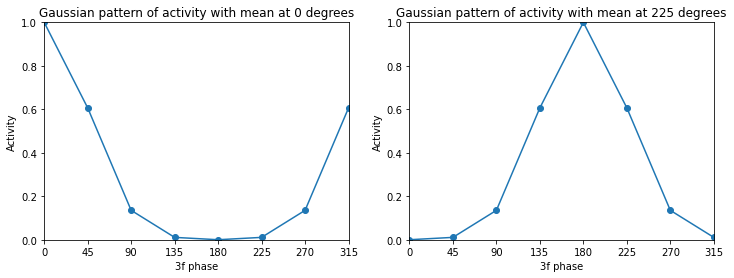

In [5]:
A, B = gabor_stimuli()
#Plot examples of stimuli at 0deg and 225deg
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.set_xlabel('3f phase')
ax2.set_xlabel('3f phase')
ax1.set_title('Gaussian pattern of activity with mean at 0 degrees')
ax2.set_title('Gaussian pattern of activity with mean at 225 degrees')
ax1.set_ylabel('Activity')
ax2.set_ylabel('Activity')
ax1.set_xlim((0, 1))
ax2.set_xlim((0, 1))
ax1.set_ylim((0, 1))
ax2.set_ylim((0, 1))
ax1.set_xticks(np.arange(0, 360, 45))
ax2.set_xticks(np.arange(0, 360, 45))
ax1.plot(np.arange(0, 360, 45), B[0][:8],'o-')
ax2.plot(np.arange(0, 360, 45), A[2][:8],'o-')

In [6]:
def test_model(lVF, rVF, trials, stimuli, labels):
    left_resp = np.zeros((7, 8, 3, trials))
    right_resp = np.zeros((7, 8, 3, trials))
    for t in range(trials):
        for i, s in enumerate(stimuli):
            y_l = lVF.activation(s, 0)
            y_r = rVF.activation(s, 0)
                
            left_resp[:,i, 0,t] = y_l
            right_resp[:,i, 0,t] = y_r
            
            y_l = lVF.activation(y_l, 1)
            y_r = rVF.activation(y_r, 1)
            
            left_resp[:,i, 1,t] = y_l
            right_resp[:,i, 1,t] = y_r
            
            y_l = lVF.activation(y_l, 2, cat_input=labels[i])
            y_r = rVF.activation(y_r, 2, cat_input=labels[i])
            
            left_resp[:,i, 2, t] = y_l
            right_resp[:,i, 2, t] = y_r
    
    return left_resp, right_resp
    

def pre_train_model(lVF, rVF, epochs, A, B):
    #Generate pre-training sequence where 0 is left and 1 is right
    training_sequence = np.repeat([0,1], epochs/2)
    np.random.shuffle(training_sequence)
    pre_training_set = np.concatenate((A,B))
    zero_stim = np.zeros(9)
    for vf in training_sequence:
        np.random.shuffle(pre_training_set)
        for stim in pre_training_set:          
            if vf == 0:
                gets_stim = lVF
                no_stim = rVF
            else:
                gets_stim = rVF
                no_stim = lVF
            
            #Precortical for both visual fields
            y_stim0 = gets_stim.activation(stim, 0)
            y_no0 = no_stim.activation(zero_stim, 0)
            gets_stim.update(stim, 0)
            no_stim.update(zero_stim, 0)
            
            #Early cortical 
            y_stim1 = gets_stim.activation(y_stim0, 1)
            y_no1 = no_stim.activation(y_no0, 1) 
            gets_stim.update(y_stim0, 1)             
            no_stim.update(y_no0, 1)
            
            #Ventral visual 
            gets_stim.activation(y_stim1, 2)
            no_stim.activation(y_no1, 2)
            gets_stim.update(y_stim1, 2)
            no_stim.update(y_no1, 2)

def category_train(lVF, rVF, epochs, A, B):
    stim = np.concatenate((B[:2], A, B[2:]))
    zero_stim = np.zeros(9)
    
    a = [2,3,4,5]
    b = [0,1,6,7]
    
    labels = np.array([1, 1, 0, 0, 0, 0, 1, 1])
    
    within_A = np.array(list(itertools.permutations(a, 2)))
    within_B = np.array(list(itertools.permutations(b, 2)))
    all_within = np.concatenate((within_A, within_B))
    between = np.array(list(itertools.permutations(np.arange(0, 8, 1), 2)))
    between = between[np.all(np.any((between-all_within[:, None]), axis=2), axis=0)]
    stim_ind = np.concatenate((all_within, between))

    #Double training sequence
    random_sequence_stim = np.arange(0, 56, 1)
    
    
    #Single training sequence
    random_sequence_vf = np.repeat([0,1], 4)
    np.random.shuffle(random_sequence_vf)
    random_sequence_stim2 = np.arange(0, 8, 1)
    
    for e in range(epochs):
        np.random.shuffle(random_sequence_stim)
        np.random.shuffle(random_sequence_stim2)
        
        #Double training
        for i in random_sequence_stim:
            s = stim_ind[i]
            s_left = stim[s[0]]
            s_right = stim[s[1]]
            l_left = labels[s[0]]
            l_right = labels[s[1]]
            
            #Precortical for both visual fields
            y_l = lVF.activation(s_left, 0)
            y_r = rVF.activation(s_right, 0)
            lVF.update(s_left, 0)
            rVF.update(s_right, 0)
            
            #Early cortical 
            y_l = lVF.activation(y_l, 1)
            y_r = rVF.activation(y_r, 1) 
            lVF.update(y_l, 1)             
            rVF.update(y_r, 1)
            
            #Ventral visual 
            lVF.activation(y_l, 2, cat_input=l_left)
            rVF.activation(y_r, 2, cat_input=l_right)
            lVF.update(y_l, 2, cat_input=l_left, category_training=True)
            rVF.update(y_r, 2, cat_input=l_right, category_training=True)
        
        #Single training
        for i in range(3):
            for j in range(8):                
                if random_sequence_vf[j] == 0:
                    gets_stim = lVF
                    no_stim = rVF
                else:
                    gets_stim = rVF
                    no_stim = lVF
                    
                s = random_sequence_stim2[j]
                s_stim = stim[s]
                l_stim = labels[s]
                
                #Precortical for both visual fields
                y_stim = gets_stim.activation(s_stim, 0)
                y_zero = no_stim.activation(zero_stim, 0)
                gets_stim.update(s_stim, 0)
                no_stim.update(zero_stim, 0)

                #Early cortical 
                y_stim = gets_stim.activation(y_stim, 1)
                y_zero = no_stim.activation(y_zero, 1) 
                gets_stim.update(y_stim, 1)             
                no_stim.update(y_zero, 1)

                #Ventral visual 
                gets_stim.activation(y_stim, 2, cat_input=l_stim)
                no_stim.activation(y_zero, 2)
                gets_stim.update(y_stim, 2, cat_input=l_stim, category_training=True)
                no_stim.update(y_zero, 2)